In [1]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import collections
import re
import string

In [2]:
import os
import pandas as pd
import numpy as np
import collections
import re
import string
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.test.utils import get_tmpfile
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
nltk.download('stopwords')
nltk.download('wordnet')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
import tensorflow as tf
from tensorflow import keras
from keras import initializers
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
proj_dir='/content/drive/MyDrive/Colab Notebooks/doc2vec/' #give your project directory here. data sets should be in this location

In [6]:
'''this function is used to read text files.'''
def read_txt_file(file_name):
    with open(file_name,encoding="utf8", errors='ignore') as f:
        ###extract the boady of the text###
        line = f.readline()
        txt=''
        txt=txt+' '+line
        while line:
            line = f.readline()
            txt=txt+' '+line
        ###################################
    f.close()
    return(txt)

In [7]:
stop_words=set(stopwords.words('english'))#load stop words
punctuations=string.punctuation #get punctuations
lemmatizer = WordNetLemmatizer()
'''this function is used to clean text'''
def clean_txt(txt):
    txt=txt.lower() #set all characters to lowercase
    sentences=txt.split('\n')
    txt = ' '.join([i for i in sentences if not ':' in i])#remove headers
    txt = ''.join([i for i in txt if not i.isdigit()])#remove numbers

    ###remove urls and emails###
    words=txt.split()
    txt = ' '.join([i for i in words if not '@' in i and not '.com' in i and not  'http:' in i])
    #######################################

    ###remove punctuations###
    for character in punctuations:
        txt = txt.replace(character, '')
    #########################################
    
    ###remove stop words and lemmatize###
    words=txt.split()
    filtered_txt = ' '.join([lemmatizer.lemmatize(i) for i in words if not i in stop_words])
    #####################################
    
    return(filtered_txt)


In [8]:
def load_and_clean_data(location):    
    y=os.listdir(location)#get the list of folder
    txts=[]
    txts_cleaned=[]
    folder_array=[]
    file_array=[]
    for i in range(len(y)):
        text_file_names=os.listdir(location+'/'+y[i]) #get the list of files
        for text_file_name in text_file_names:
                file_array.append(text_file_name)
                txt=read_txt_file(location+'/'+y[i]+'/'+text_file_name) #read the text file
                txts.append(txt)
                txts_cleaned.append(clean_txt(txt)) #clean the text
                folder_array.append(y[i])

    ###create a data frame###
    df=pd.DataFrame()
    df['texts']=txts
    df['text cleaned']=txts_cleaned
    df['folder name']=folder_array
    df['file name']=file_array
    ########################
    return (df)


In [9]:
df_train=load_and_clean_data(proj_dir+'20news-bydate-train')
df_test=load_and_clean_data(proj_dir+'20news-bydate-test')


# Creating Training,Validation and Testing Variables/Data

In [10]:
#Shuffling Data for Splitting Randomly
seed=1337
rng = np.random.RandomState(seed)
rng.shuffle(df_train.texts.values.tolist())
rng = np.random.RandomState(seed)
rng.shuffle(np.unique(df_train['folder name'].values.tolist()))


In [11]:
#Extracted the Required Data.
X = df_train['texts']
y = df_train['folder name']
X_test=df_test['texts']
y_test=df_test['folder name']


In [12]:
#Splitting the shuffled Training data into Training and Validation set
sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=0)
sss.get_n_splits(X, y)
print(sss)
for train_index, val_index in sss.split(X, y):
  print("train_index:", train_index, "val_index:", val_index)
  X_train, X_val = X[train_index], X[val_index]
  Y_train, Y_val = y[train_index], y[val_index]
  

StratifiedShuffleSplit(n_splits=2, random_state=0, test_size=0.2,
            train_size=None)
train_index: [2497 1028 6922 ... 5430 7132 6141] val_index: [10345 11003  7550 ...   433 10070  1085]
train_index: [ 6628  7618  7267 ... 10777   647  6312] val_index: [10826  9530  3868 ...  8793  5443  4802]


In [13]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# **Creating Text Vectorization from Training Dataset**

In [14]:
#Creating vectorizer and adapting to the training data to be use for all data,restriced to 20,000 vocabulary
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(X_train.values.tolist())
vectorizer.adapt(text_ds)

In [15]:
#testing vectorizer
vectorizer.get_vocabulary()[0:5]

['', '[UNK]', 'the', 'to', 'of']

In [16]:
#Creating word_index mapping to the vocabulary created from the vectorizer
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [17]:
#Testing word_index
test = ["cat", "sat", "mat"]
[word_index[w] for w in test]

[3508, 2751, 7018]

### Get Embeddings-Using GLOVE word2vec
GloVe is an unsupervised learning algorithm for obtaining vector representations for words

In [36]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-04-11 14:34:35--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-11 14:34:35--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-11 14:34:35--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

# **Training the Embedding**

In [37]:
embeddings_index = {}
f = open('/content/glove.6B.100d.txt',encoding='utf8')# source of the downloaded glove files-use the 100d.txt
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 400000 word vectors in Glove 6B 100d.


In [38]:
num_tokens = len(voc) + 2
embedding_dim = 100
hits = 0
misses = 0
embedding_matrix = np.random.random((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 17440 words (2560 misses)


# **PreTrained Embedding**

In [43]:
embedding_layer = Embedding(
num_tokens,
embedding_dim,
embeddings_initializer=keras.initializers.Constant(embedding_matrix),
trainable=False,)
embedding_layer

## **Preparing Data input for Models**

In [23]:
class_names=y.unique()
label_names=list(class_names)
label_index=(np.unique(label_names, return_inverse=True)[1])
label_code=(np.unique(y, return_inverse=True)[1])

In [24]:
print(X_train.shape, X_val.shape)
print(Y_train.shape, Y_val.shape)

(9051,) (2263,)
(9051,) (2263,)


In [25]:
x_train = vectorizer(np.array([[s] for s in X_train.values.tolist()])).numpy()
x_val = vectorizer(np.array([[s] for s in X_val.values.tolist()])).numpy()
x_test = vectorizer(np.array([[s] for s in X_test.values.tolist()])).numpy()
type(x_test)

numpy.ndarray

In [26]:
y_train=np.array(np.unique(Y_train, return_inverse=True)[1])
y_val=(np.unique(Y_val, return_inverse=True)[1])
y_test=(np.unique(y_test, return_inverse=True)[1])

# **1 dimensional CNN | Conv1D Maxpooling and GlobalMax Pooling Using PreTrained Embedding**

In [44]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
preds = layers.Dense(len(label_names), activation="softmax")(x)
model1 = keras.Model(int_sequences_input, preds)
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_4 (Conv1D)           (None, None, 128)         64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_5 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

# **Graphical represention of Model1**

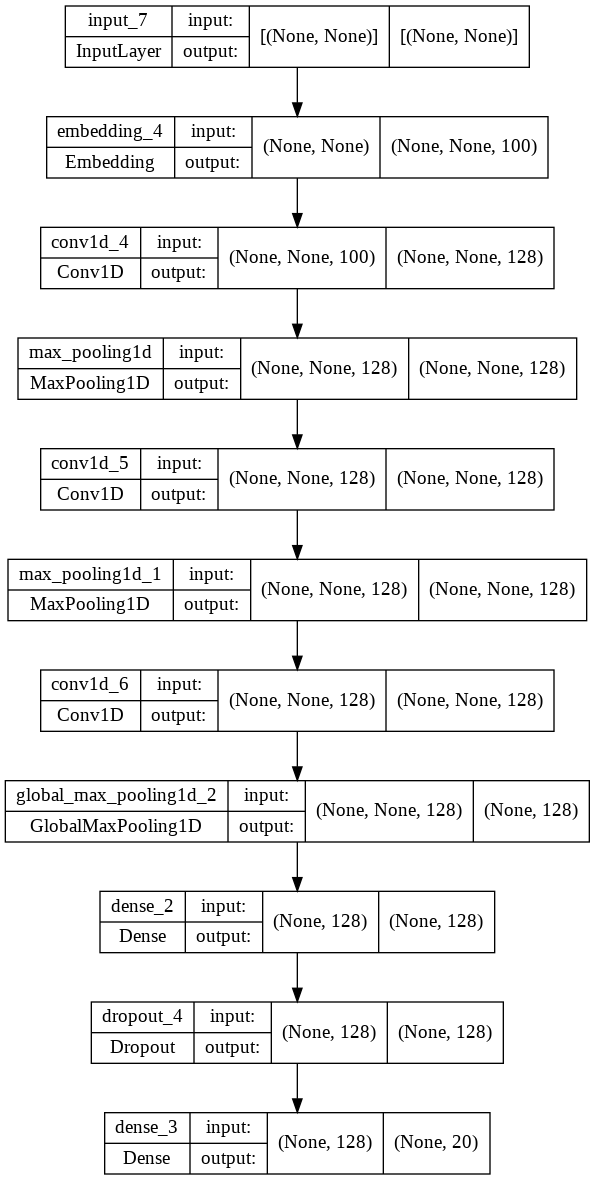

In [45]:
keras.utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)

# **Training Model1**

In [46]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 10 epochs"
        patience=10,
        verbose=1,
    )
]

In [47]:
epochs = 50
batch_size=64
model1.compile(
    loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"]
)
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history1=model1.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val),batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
142/142 [==============================] - 18s 123ms/step - loss: 2.8123 - acc: 0.1056 - val_loss: 2.3314 - val_acc: 0.2307
Epoch 2/50
142/142 [==============================] - 18s 127ms/step - loss: 2.0899 - acc: 0.2775 - val_loss: 1.7473 - val_acc: 0.3831
Epoch 3/50
142/142 [==============================] - 17s 121ms/step - loss: 1.5852 - acc: 0.4443 - val_loss: 1.7754 - val_acc: 0.3862
Epoch 4/50
142/142 [==============================] - 17s 120ms/step - loss: 1.2269 - acc: 0.5736 - val_loss: 1.1093 - val_acc: 0.6076
Epoch 5/50
142/142 [==============================] - 17s 120ms/step - loss: 0.9900 - acc: 0.6428 - val_loss: 1.0614 - val_acc: 0.6182
Epoch 6/50
142/142 [==============================] - 19s 132ms/step - loss: 0.7992 - acc: 0.7224 - val_loss: 0.9648 - val_acc: 0.6894
Epoch 7/50
142/142 [==============================] - 17s 121ms/step - loss: 0.6372 - acc: 0.7745 - val_loss: 0.8651 - val_acc: 0.7088
Epoch 8/50
142/142 [==============================] - 1

# **Plotting the Accuracy and validation Loss for model1**

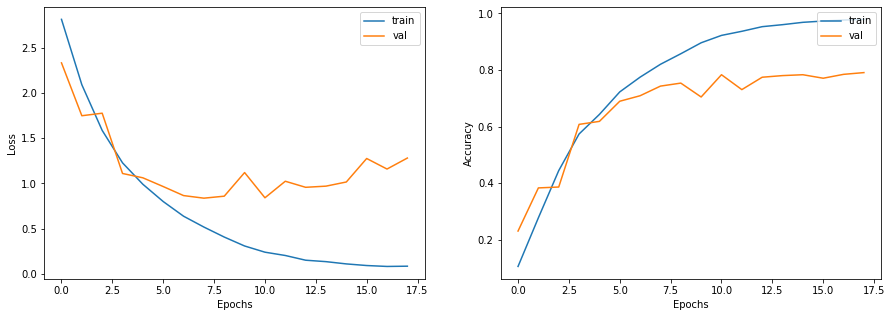

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history1.history["loss"])
ax1.plot(history1.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history1.history["acc"])
ax2.plot(history1.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model1 with testing dataset**

In [49]:
_, test_accuracy = model1.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 70.46%


# **Predicting using unknow raw text-Model1**

In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model1(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict([['Update and Re-fit a Model Call Description. update will update and (by default) re-fit a model']])

class_names[np.argmax(probabilities[0])]

'comp.os.ms-windows.misc'

## **1 dimensional CNN | Conv1D-without using Pre-trained Embedding**

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow.keras import layers

# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(num_tokens, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a multiclass unit output layer, and squash it with a softmax:
predictions = layers.Dense(len(label_names), activation="softmax", name="predictions")(x)

model2 = tf.keras.Model(inputs, predictions)

# Compile the model with multiclass crossentropy loss and an rmsprop optimizer.
model2.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
print("Simple Neural Network")
model2.summary()

# **Graphical representation of Model2**


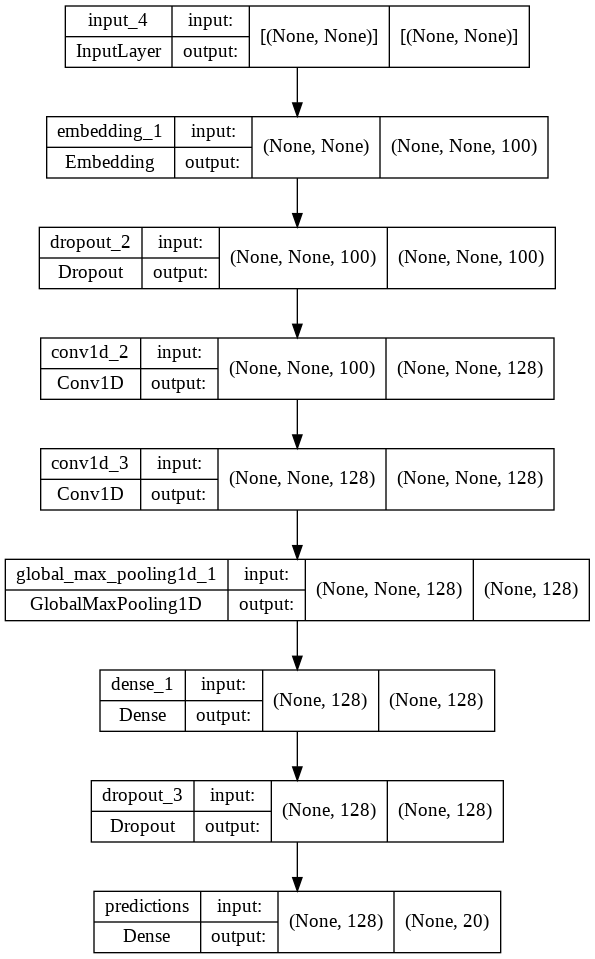

In [28]:
keras.utils.plot_model(model2, "multi_input_and_output_model.png", show_shapes=True)

# **Training of Model2**

In [29]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [30]:
epochs = 50
batch_size=64
# Fit the model using the train and test datasets.
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history2=model2.fit(x_train, y_train,validation_data=(x_val, y_val), epochs=epochs,batch_size=batch_size,callbacks=callbacks)

Epoch 1/50
142/142 [==============================] - 19s 130ms/step - loss: 2.9553 - accuracy: 0.0705 - val_loss: 2.7553 - val_accuracy: 0.0963
Epoch 2/50
142/142 [==============================] - 18s 128ms/step - loss: 2.5917 - accuracy: 0.1253 - val_loss: 2.3573 - val_accuracy: 0.1631
Epoch 3/50
142/142 [==============================] - 18s 128ms/step - loss: 2.2726 - accuracy: 0.1899 - val_loss: 2.1292 - val_accuracy: 0.2408
Epoch 4/50
142/142 [==============================] - 18s 129ms/step - loss: 1.9358 - accuracy: 0.2941 - val_loss: 1.7596 - val_accuracy: 0.4189
Epoch 5/50
142/142 [==============================] - 18s 129ms/step - loss: 1.5188 - accuracy: 0.4444 - val_loss: 1.4241 - val_accuracy: 0.5205
Epoch 6/50
142/142 [==============================] - 18s 130ms/step - loss: 1.1271 - accuracy: 0.6042 - val_loss: 1.0475 - val_accuracy: 0.6646
Epoch 7/50
142/142 [==============================] - 18s 130ms/step - loss: 0.8543 - accuracy: 0.7071 - val_loss: 0.8898 - val_ac

# **Plotting Accuracy and validation loss of Model2**

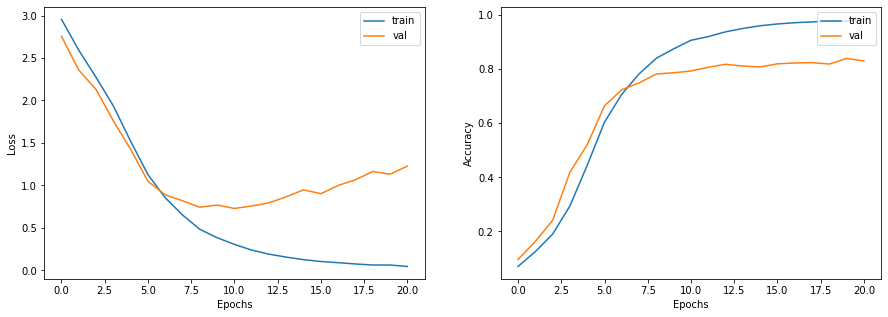

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history2.history["loss"])
ax1.plot(history2.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history2.history["accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model2 with Test dataset**

In [33]:
_, test_accuracy = model2.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 71.75%


# **Predicting unknown text with Model2**

In [34]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model2(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [['As a sanity check, if the embedding matrix has been generated properly. In the above, when I saw the first five entries of\nthe training set, the first entry was\n']]
)

class_names[np.argmax(probabilities[0])]
#df_train.texts[500]

'comp.sys.mac.hardware'

# **RNN-Bidirectional LSTM Model 50 Unit**

In [50]:
sequence_input = Input(shape=(200,), dtype='int64')
embedded_sequences = embedding_layer(sequence_input)
l_lstm = Bidirectional(LSTM(50))(embedded_sequences)
preds = Dense(len(label_names), activation='softmax')(l_lstm)
model3 = Model(sequence_input, preds)
model3.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

print("Bidirectional LSTM")
model3.summary()

Bidirectional LSTM
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_4 (Embedding)     multiple                  2000200   
                                                                 
 bidirectional (Bidirectiona  (None, 100)              60400     
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 20)                2020      
                                                                 
Total params: 2,062,620
Trainable params: 62,420
Non-trainable params: 2,000,200
_________________________________________________________________


# **Graphical representation of model3**

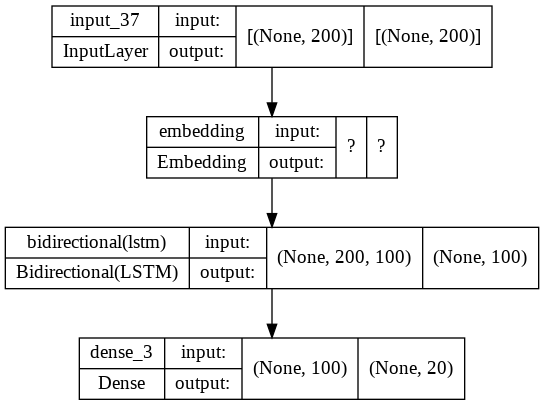

In [ ]:
keras.utils.plot_model(model3, "multi_input_and_output_model.png", show_shapes=True)

# **Training Model3**

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [ ]:
epochs=30
batch_size=20
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)
history3=model3.fit(x_train, y_train, validation_data=(x_val,y_val),epochs=epochs, batch_size=batch_size,callbacks=callbacks)

Epoch 1/30
453/453 [==============================] - 63s 140ms/step - loss: 0.3497 - acc: 0.8879 - val_loss: 0.7452 - val_acc: 0.7936
Epoch 2/30
453/453 [==============================] - 64s 140ms/step - loss: 0.2254 - acc: 0.9306 - val_loss: 0.8112 - val_acc: 0.7773
Epoch 3/30
453/453 [==============================] - 64s 140ms/step - loss: 0.1662 - acc: 0.9515 - val_loss: 0.7208 - val_acc: 0.7989
Epoch 4/30
453/453 [==============================] - 64s 141ms/step - loss: 0.1548 - acc: 0.9544 - val_loss: 0.7579 - val_acc: 0.7976
Epoch 5/30
453/453 [==============================] - 64s 141ms/step - loss: 0.1134 - acc: 0.9675 - val_loss: 0.7512 - val_acc: 0.8051
Epoch 6/30
453/453 [==============================] - 65s 144ms/step - loss: 0.0991 - acc: 0.9739 - val_loss: 0.8126 - val_acc: 0.7981
Epoch 7/30
453/453 [==============================] - 64s 141ms/step - loss: 0.0964 - acc: 0.9741 - val_loss: 0.7504 - val_acc: 0.8140
Epoch 8/30
453/453 [==============================] - 7

## **Plotting accuracy and loss of Model3**

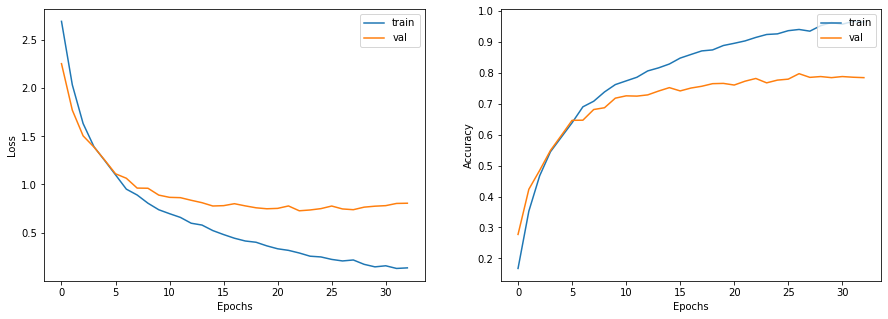

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history3.history["loss"])
ax1.plot(history3.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history3.history["acc"])
ax2.plot(history3.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

# **Testing Model3 on Testing data**

In [ ]:
_, test_accuracy = model3.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 70.26%


# **Predicting with Model3**

In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model3(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [['Jon playes cricket His favourite player is MS DhoniSometimes he loves to play football']]
)

class_names[np.argmax(probabilities[0])]

'rec.sport.baseball'

# **1 dimensional CNN MODEL- Developed as a function**

In [ ]:
def ConvNet1(embeddings, num_tokens, embedding_dim, label_code):
    
    embedding_layer = Embedding(
        num_tokens,
        embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        trainable=False,)
    
    sequence_input = Input(shape=(None,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.MaxPooling1D(5)(x)
    x = layers.Conv1D(128, 5, activation="relu")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    preds = Dense(len(label_names), activation='softmax')(x)
    model = keras.Model(sequence_input, preds)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer="adam",
                  metrics=['acc'])
    model.summary()
    return model

In [ ]:
model4 = ConvNet1(embedding_matrix, num_tokens,embedding_dim,label_code)

Model: "model_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_47 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_7 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_20 (Conv1D)          (None, None, 128)         64128     
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_21 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                     

# **Graph of Model4**

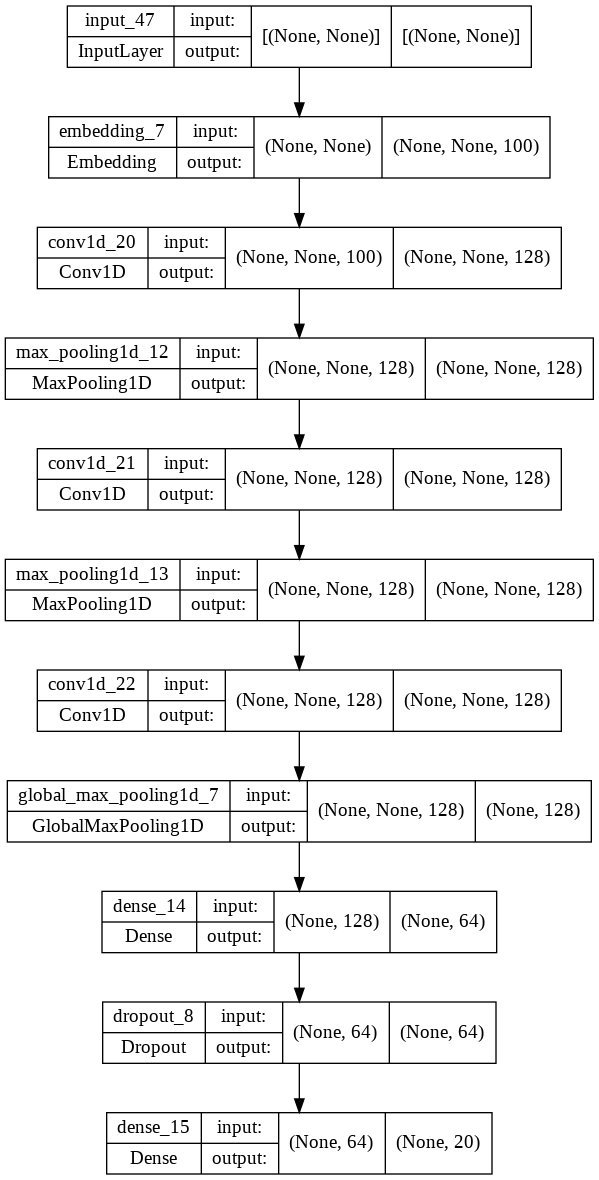

In [ ]:
keras.utils.plot_model(model4, "multi_input_and_output_model.png", show_shapes=True)

# **Training of Model4**

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=10,
        verbose=1,
    )
]

In [ ]:
epochs=50
batch_size=64
cp=ModelCheckpoint('model_1.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

In [ ]:
model4 = ConvNet1(embedding_matrix, num_tokens, embedding_dim,label_code)
history4 = model4.fit(x_train, y_train, epochs=epochs, shuffle=True,validation_data=(x_val,y_val), batch_size=batch_size,callbacks=callbacks)

Model: "model_48"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_49 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_9 (Embedding)     (None, None, 100)         2000200   
                                                                 
 conv1d_26 (Conv1D)          (None, None, 128)         64128     
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                            
                                                                 
 conv1d_27 (Conv1D)          (None, None, 128)         82048     
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, None, 128)        0         
 g1D)                                                     

## **Plotting accuracy and loss of Model4**

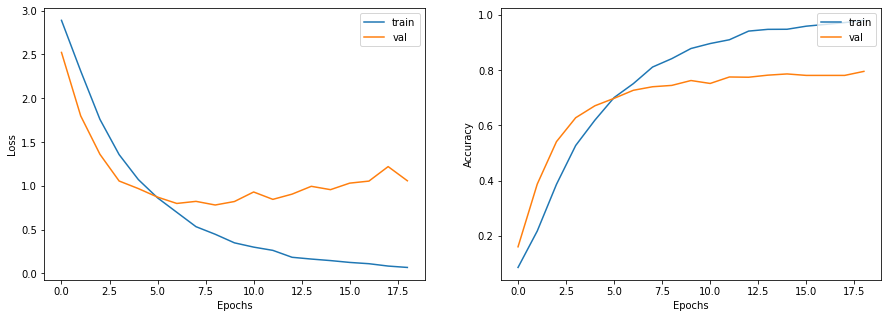

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history4.history["loss"])
ax1.plot(history4.history["val_loss"])
ax1.legend(["train", "val"], loc="upper right")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(history4.history["acc"])
ax2.plot(history4.history["val_acc"])
ax2.legend(["train", "val"], loc="upper right")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

## **Testing Model4**

In [ ]:
_, test_accuracy = model4.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

Test accuracy: 69.66%


# **Predicting with Model4**

In [ ]:
string_input = keras.Input(shape=(1,), dtype="string")
x = vectorizer(string_input)
preds = model4(x)
end_to_end_model = keras.Model(string_input, preds)

probabilities = end_to_end_model.predict(
    [["Jon playes cricket His favourite player is MS Dhoni Sometimes he loves to play football"]]
)

class_names[np.argmax(probabilities[0])]

'rec.sport.hockey'